In [1]:
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import astropy.units as u
import astropy.constants as c
from astropy.table import Table
import numpy as np
from matplotlib import colors
import lmfit
import glob
from lmfit.models import GaussianModel, SplineModel, PolynomialModel
import pandas as pd
from astropy.io import ascii

In [2]:
def plot_data(obj,percentile = [1, 99],use_log = False):
    if(use_log):
        plt.imshow(obj, origin='lower', cmap='gray', clim=(np.percentile(obj,percentile[0]), np.percentile(obj,percentile[1])),norm=colors.LogNorm())
    else:
        plt.imshow(obj, origin='lower', cmap='gray', clim=(np.percentile(obj,percentile[0]), np.percentile(obj,percentile[1])))
    plt.colorbar()

def read_file(file_name):
    return fits.open(file_name)['PRIMARY'].data.astype(float)

In [3]:
files = glob.glob("./20230507/*.fits")
files = np.sort(files)

In [4]:
slit_w = 30 * u.arcsecond
scale = 0.37 * u.arcsecond
slit_pixel_w = int(slit_w / scale) + 20
slit_pixel_w

101

In [5]:
Obslog = Table(
                    names=("File", "Date", "UTC", "ra", "dec", "observer", "objid", "airmass", "exptime", "obstype"
                    ),
                    meta={"name": "Observation Log"},
                    dtype=("U64", "U64", "U64", "U64", "U64", "U64", "U64", "float64", "float64", "U64"
                          )
                    )
for i in files:
      open_file = fits.open(i)
      header_file = open_file[0].header
      row = [i, header_file["DATE"], header_file["TIME"], header_file["RA"],
             header_file["DEC"], header_file["OBSERVER"], header_file["OBJECT"], 
             header_file["AIRMASS"], header_file["EXPTIME"], header_file["OBSTYPE"]]
      Obslog.add_row(row)
Obslog

File,Date,UTC,ra,dec,observer,objid,airmass,exptime,obstype
str64,str64,str64,str64,str64,str64,str64,float64,float64,str64
./20230507\image0001.fits,126,23:32:08.2,06:41:18.93,+33:31:29.1,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507\image0002.fits,126,23:33:31.8,06:42:42.78,+33:31:31.9,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507\image0003.fits,126,23:34:19.6,06:43:30.72,+33:31:33.4,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507\image0004.fits,126,23:35:08.4,06:44:19.66,+33:31:35.0,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507\image0005.fits,126,23:35:57.2,06:45:08.59,+33:31:36.6,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507\image0006.fits,126,23:36:46.0,06:45:57.55,+33:31:38.2,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507\image0007.fits,126,23:37:34.9,06:46:46.58,+33:31:39.8,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507\image0008.fits,126,23:38:23.7,06:47:35.53,+33:31:41.4,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507\image0009.fits,126,23:39:12.5,06:48:24.46,+33:31:43.0,xanderberylcarlos,lampon,1.0,45.0,flat


In [6]:
xb_data = Obslog[np.where("xanderberyl" == Obslog["observer"])]
flat_table = Obslog[np.where("flat" == Obslog["obstype"])]
standard = Obslog[np.where("HD 162208" == Obslog["objid"])]

In [7]:
flat_table_on = flat_table[np.where("lampon" == flat_table["objid"])]
flat_table_off = flat_table[np.where("lampoff" == flat_table["objid"])]

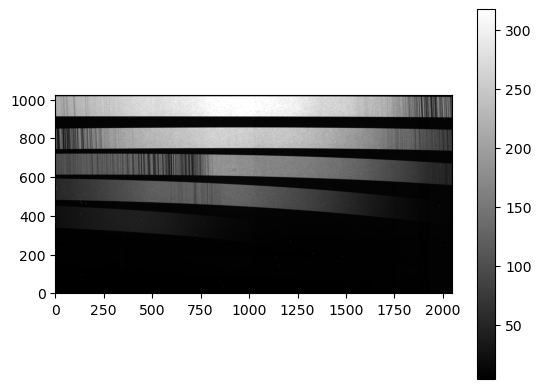

In [8]:
flat_data_on = []
for i in flat_table_on:
    flat_data_on.append((read_file(i["File"])) / i["exptime"])
flat_data_on = np.median(np.asarray(flat_data_on), axis=0)
flat_on = flat_data_on
plot_data(flat_on)

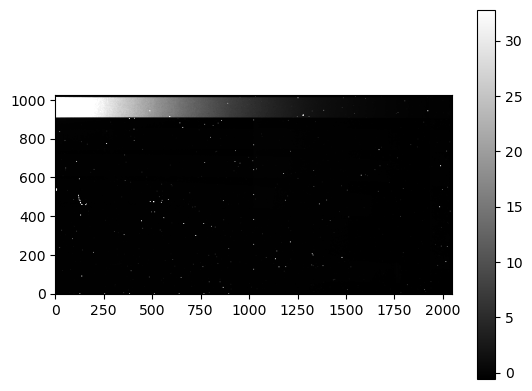

In [9]:
flat_data_off = []
for i in flat_table_off:
    flat_data_off.append((read_file(i["File"])) / i["exptime"])
flat_data_off = np.median(np.asarray(flat_data_off), axis=0)
flat_off = flat_data_off
plot_data(flat_off)

1.215775935981709


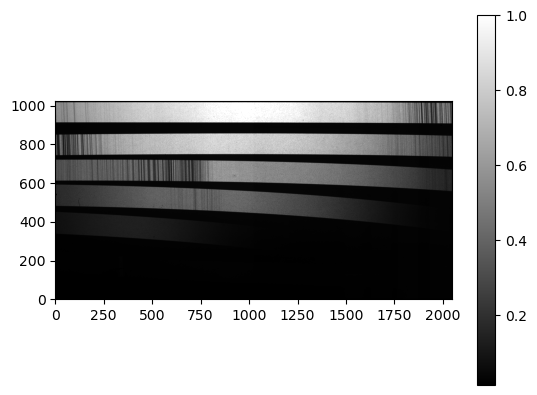

In [10]:
flat_counts = flat_on - flat_off
flat = flat_counts / np.percentile(flat_counts, 99)
#flat = flat_counts / np.max(flat_counts)
print(np.max(flat))
plot_data(flat)
plt.show()

In [11]:
def read_file_flat(file_name, f = flat):
    return read_file(file_name)/f

In [15]:
trace = np.flip(Table.from_pandas(pd.read_csv("tspec_traces.csv")))

In [34]:
def rectify(data, trace, slit_w, order, offset = 0):
    order = "order" + str(order)
    trace_order = trace[order]
    trace_line_min = np.floor(trace_order - slit_w/2).astype(int) 
    trace_line_max = trace_line_min + slit_w + offset
    rectangle = []
    for i in range(data.shape[1]):
        column = data[:,i]
        rectangle.append(column[trace_line_min[i]:trace_line_max[i]])
    rectangle = np.asarray(rectangle)
    return rectangle.T

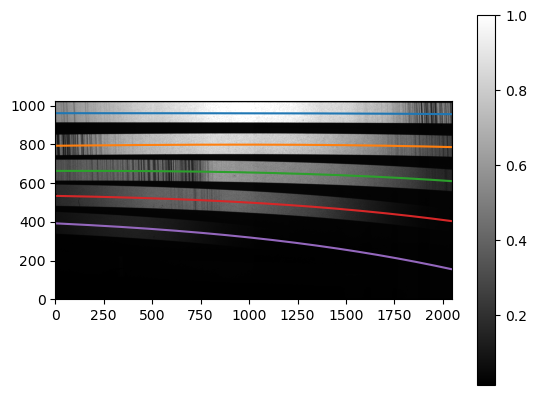

In [35]:
plot_data(flat)
plt.plot(range(2048), trace["order3"])
plt.plot(range(2048), trace["order4"])
plt.plot(range(2048), trace["order5"])
plt.plot(range(2048), trace["order6"])
plt.plot(range(2048), trace["order7"])

In [185]:
wavefunction_solution = {3 : [5.3 * 10**-13, -3.1 * 10**-9, -2.832 * 10**-4, 2.46399],
                         4 : [4.4 * 10**-13, -2.7 * 10**-9, -2.1198 * 10**-4, 1.85129],
                         5 : [3.5 * 10**-13, -2.3 * 10**-9, -1.6953 * 10**-4, 1.48323],
                         6 : [2.0 * 10**-13, -1.7 * 10**-9, -1.4152 * 10**-4, 1.23790],
                         7 : [1.0 * 10**-12, -2.9 * 10**-9, -1.208 * 10**-4, 1.06265],}

In [184]:
def wavefunction(order):
    C = wavefunction_solution[order]
    x = np.arange(0, 2048).astype(np.int64)
    return C[0] * np.power(x, 3) + C[1] * np.power(x, 2) + C[2] * np.power(x, 1) + C[3]

In [224]:
first_b_obs = xb_data[0:4]

In [210]:
twoam_std = standard[0:4]
threethrityam_std = standard[4:8]
fiveam_std = standard[8:12]

In [354]:
twoam_std_data = []
for i in twoam_std:
    twoam_std_data.append((read_file(i["File"]) / i["exptime"]))
twoam_std_data = np.array(twoam_std_data)

In [424]:
std_AB1 = (twoam_std_data[0] - twoam_std_data[1])/flat
std_AB1 = std_AB1 - np.median(std_AB1)

std_AB2 = (twoam_std_data[2] - twoam_std_data[3])/flat
std_AB2 = std_AB2 - np.median(std_AB2)

std_BA1 = (twoam_std_data[1] - twoam_std_data[0])/flat
std_BA1 = std_BA1 - np.median(std_BA1)

std_BA2 = (twoam_std_data[3] - twoam_std_data[2])/flat
std_BA2 = std_BA2 - np.median(std_BA2)

std = np.array([std_AB1, std_AB2, std_BA1, std_BA2])

In [425]:
def rectify_array(data_array, t, spw, order_num):
    data = []
    for i in data_array:
        data.append(rectify(i, t, spw , order_num))
    return np.asarray(data)


In [426]:
def rectify_ccd(data_array, t, spw):
    data = {}
    for i in range(3,8):
        data[i] = (rectify_array(data_array, t, spw, i))
    return data

In [427]:
std = rectify_ccd(std, trace, slit_pixel_w)

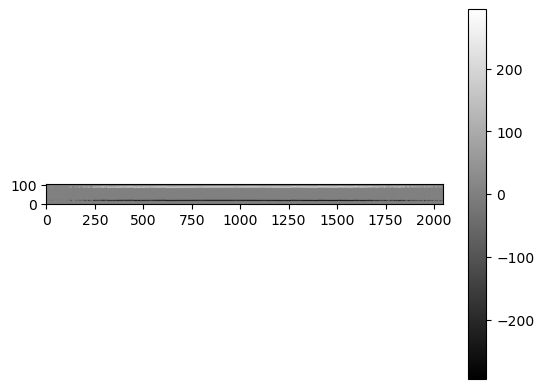

In [428]:
current_order = 4

rectangle = std[current_order][1]
plot_data(rectangle)

In [429]:
sum_h = np.median(rectangle, axis = 1)
sum_h[~np.isfinite(sum_h)] = -np.NaN
middle = int(len(sum_h) / 2)
sum_h = sum_h - np.nanmedian(sum_h)
where_max = np.nanargmax(sum_h)

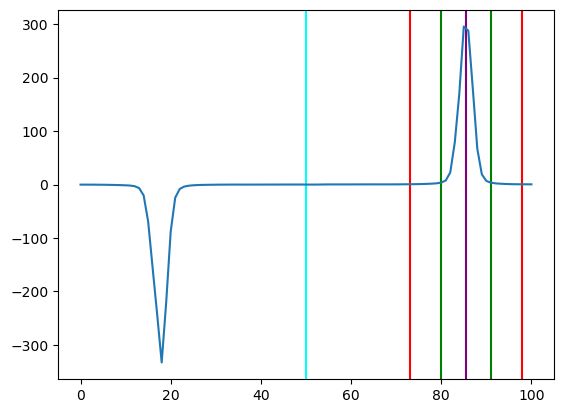

In [430]:
left_or_right = -1
if(where_max > middle):
    sum_side = sum_h[middle : len(sum_h)]
    left_or_right = 1
else:
    sum_side = sum_h[0 : middle]
    left_or_right = 0

sum_side[~np.isfinite(sum_side)] = np.NaN

model = GaussianModel(nan_policy='omit')
params = model.guess(sum_side, x = np.arange(len(sum_side)))
params["center"].value = np.nanargmax(sum_side)
result = model.fit(sum_side, params, x = np.arange(len(sum_side)))

scaler = 4
scaler_s = 8

gauss_c = result.params["center"]
gauss_s = result.params["sigma"]

l_bound = int(np.ceil(gauss_c - scaler * gauss_s)) + middle * left_or_right
r_bound = int(np.floor(gauss_c + scaler * gauss_s)) + middle * left_or_right

l_bound_s = int(np.floor(gauss_c - scaler_s * gauss_s)) + middle * left_or_right
r_bound_s = int(np.ceil(gauss_c + scaler_s * gauss_s)) + middle * left_or_right

if(where_max > middle):
    sky_pixels = np.arange(middle, l_bound_s)
else:
    sky_pixels = np.arange(r_bound_s, middle)

plt.axvline(l_bound, color = "green")
plt.axvline(r_bound, color = "green")

plt.axvline(l_bound_s, color = "red")
plt.axvline(r_bound_s, color = "red")

plt.axvline(middle, color = "cyan")
plt.axvline(result.params["center"].value + middle * left_or_right, color = "purple")

plt.plot(np.arange(len(sum_h)), sum_h)

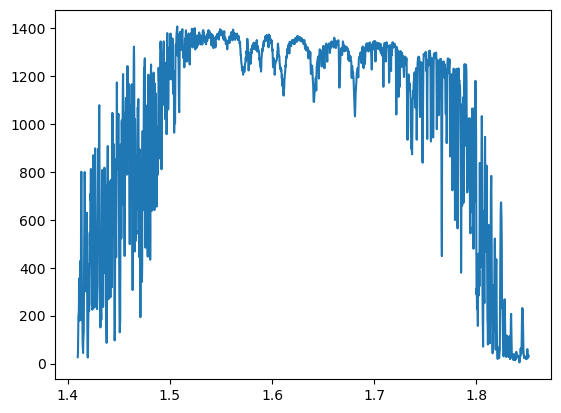

In [431]:
spectra_object = []
spectra_sky = []
star_pixels = r_bound - l_bound
spectra_table = Table()
for i in range(rectangle.shape[1]):
    col = rectangle[:,i]
    col_obj = col[l_bound:r_bound]
    col_sky = col[sky_pixels]

    sky_median = np.median(col_sky)
    spectra_sky.append(sky_median * star_pixels)

    obj_sum = np.sum(col_obj)
    spectra_object.append(obj_sum)

spectra_object = np.asarray(spectra_object)
spectra_sky = np.asarray(spectra_sky)
spectra_reduced = spectra_object - spectra_sky

spectra_table["wavelength"] = wavefunction(current_order) * u.micron
spectra_table["pixel"] = np.arange(rectangle.shape[1]) * u.pixel
spectra_table["object"] = spectra_object
spectra_table["sky"] = spectra_sky
spectra_table["reduced"] = spectra_reduced

plt.plot(wavefunction(current_order), spectra_object)


In [452]:
def get_spectra_from_rectangle(rectangle, order, plot = False):
    sum_h = np.median(rectangle, axis = 1)
    sum_h[~np.isfinite(sum_h)] = -np.NaN
    middle = int(len(sum_h) / 2)
    sum_h = sum_h - np.nanmedian(sum_h)
    where_max = np.nanargmax(sum_h)

    left_or_right = -1
    if(where_max > middle):
        sum_side = sum_h[middle : len(sum_h)]
        left_or_right = 1
    else:
        sum_side = sum_h[0 : middle]
        left_or_right = 0

    sum_side[~np.isfinite(sum_side)] = np.NaN

    model = GaussianModel(nan_policy='omit')
    params = model.guess(sum_side, x = np.arange(len(sum_side)))
    params["center"].value = np.nanargmax(sum_side)
    result = model.fit(sum_side, params, x = np.arange(len(sum_side)))

    scaler = 4
    scaler_s = 8

    gauss_c = result.params["center"]
    gauss_s = result.params["sigma"]

    l_bound = int(np.ceil(gauss_c - scaler * gauss_s)) + middle * left_or_right
    r_bound = int(np.floor(gauss_c + scaler * gauss_s)) + middle * left_or_right

    l_bound_s = int(np.floor(gauss_c - scaler_s * gauss_s)) + middle * left_or_right
    r_bound_s = int(np.ceil(gauss_c + scaler_s * gauss_s)) + middle * left_or_right

    if(where_max > middle):
        sky_pixels = np.arange(middle, l_bound_s)
    else:
        sky_pixels = np.arange(r_bound_s, middle)

    if(plot):
        plt.axvline(l_bound, color = "green")
        plt.axvline(r_bound, color = "green")

        plt.axvline(l_bound_s, color = "red")
        plt.axvline(r_bound_s, color = "red")

        plt.axvline(middle, color = "cyan")
        plt.axvline(result.params["center"].value + middle * left_or_right, color = "purple")

        plt.plot(np.arange(len(sum_h)), sum_h)
        plt.show()

    spectra_object = []
    spectra_sky = []
    star_pixels = r_bound - l_bound
    spectra_table = Table()
    for i in range(rectangle.shape[1]):
        col = rectangle[:,i]
        col_obj = col[l_bound:r_bound]
        col_sky = col[sky_pixels]

        sky_median = np.median(col_sky)
        spectra_sky.append(sky_median * star_pixels)

        obj_sum = np.sum(col_obj)
        spectra_object.append(obj_sum)

    spectra_object = np.asarray(spectra_object)
    spectra_sky = np.asarray(spectra_sky)
    spectra_reduced = spectra_object - spectra_sky

    spectra_table["wavelength"] = wavefunction(order) * u.micron
    spectra_table["pixel"] = np.arange(rectangle.shape[1]) * u.pixel
    spectra_table["object"] = spectra_object
    spectra_table["sky"] = spectra_sky
    spectra_table["reduced"] = spectra_reduced

    if(plot):
        plt.plot(spectra_table["wavelength"], spectra_table["reduced"])
        plt.show()
    
    return spectra_table


In [453]:
def get_all_spectra(data, plot = False):
    order_spectra = {}
    for order in range(3, 8):
        order_data = data[order]
        data_list = []
        for image_num in range(order_data.shape[0]):
            image = order_data[image_num]
            data_list.append(get_spectra_from_rectangle(image, order, plot = plot))
        order_spectra[order] = data_list
    return order_spectra
        


In [454]:
standard_star_reduced = get_all_spectra(std)

In [455]:
def median_each_order(spectra_dict):
    order_spectra = {}
    for order in range(3,8):
        object_order = spectra_dict[order]
        tab_spectra = Table()
        obj_spectra = []
        sky_spectra = []
        red_spectra = []
        tab_spectra["wavelength"] = object_order[0]["wavelength"]
        tab_spectra["pixel"] = object_order[0]["pixel"]
        for i in object_order:
            obj_spectra.append(i["object"])
            sky_spectra.append(i["sky"])
            red_spectra.append(i["reduced"])

        obj_spectra = np.asarray(obj_spectra)
        sky_spectra = np.asarray(sky_spectra)
        red_spectra = np.asarray(red_spectra)

        tab_spectra["object"] = np.median(obj_spectra, axis = 0)
        tab_spectra["sky"] = np.median(sky_spectra, axis = 0)
        tab_spectra["reduced"] = np.median(red_spectra, axis = 0)

        order_spectra[order] = tab_spectra
    return order_spectra

In [456]:
standard_star_reduced_median = median_each_order(standard_star_reduced)

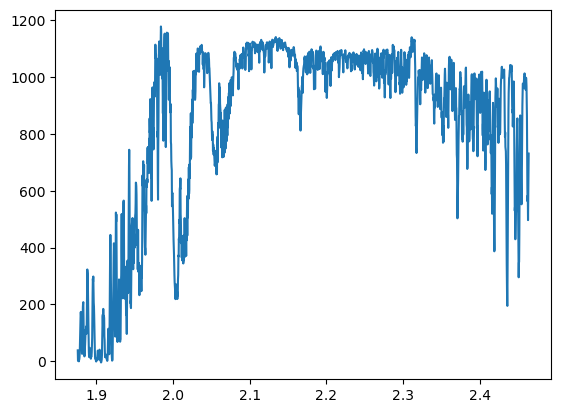

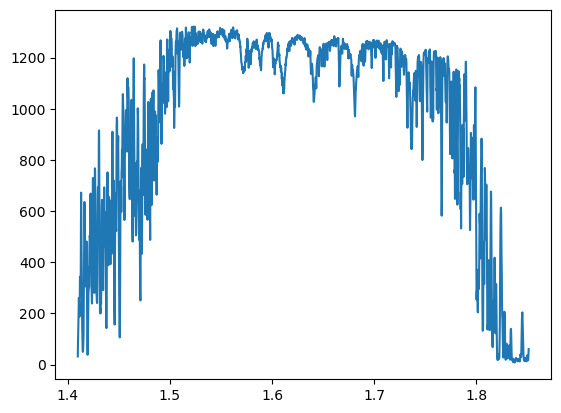

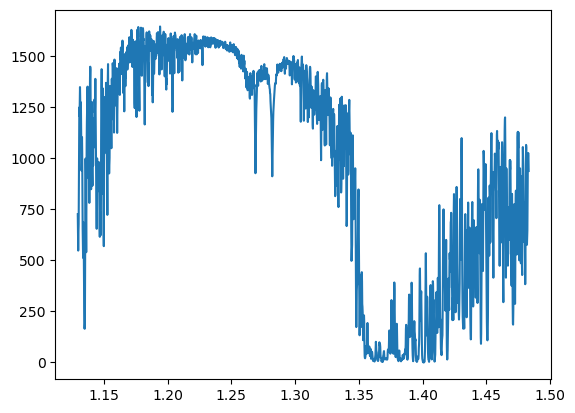

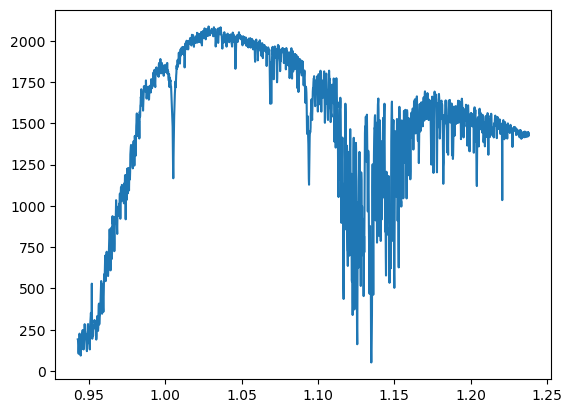

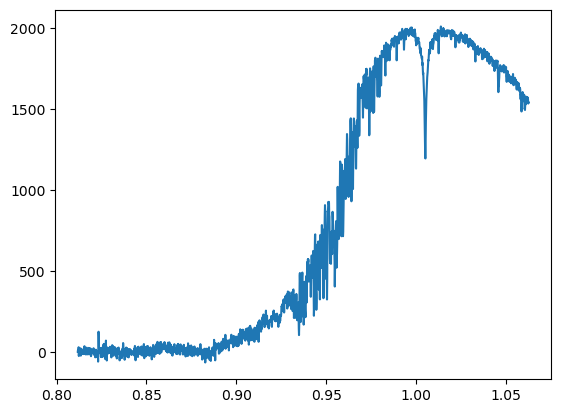

In [518]:
for i in range(3,8):
    order_data = standard_star_reduced_median[i]
    plt.plot(order_data["wavelength"], order_data["reduced"])
    plt.show()

In [492]:
def inverse_wavefunction(p, order):
    C = wavefunction_solution[order]
    x = np.linspace(2048, 0, 2049000).astype(np.float64)
    y = C[0] * np.power(x, 3) + C[1] * np.power(x, 2) + C[2] * np.power(x, 1) + C[3]
    return np.interp(p, y, x)

In [556]:
wavelength = np.array([])
counts = np.array([])
i = 4

order_data_l = standard_star_reduced_median[i]
order_data_s = standard_star_reduced_median[i+1]
min_l = np.min(order_data_l["wavelength"])
max_s = np.max(order_data_s["wavelength"])
if(max_s < min_l):
    wavelength = np.append(wavelength, order_data_l["wavelength"])
    counts = np.append(counts, order_data_l["reduced"])
else:
    does_not_overlap_l = order_data_l[np.where(order_data_l["wavelength"] > max_s)]
    wavelength = np.append(wavelength, does_not_overlap_l["wavelength"])
    counts = np.append(counts, does_not_overlap_l["reduced"])

    does_overlap_l = order_data_l[np.where(order_data_l["wavelength"] < max_s)]
    overlap_wavelength_l = does_overlap_l["wavelength"].value
    overlap_counts_l = does_overlap_l["reduced"].value
    does_overlap_s = order_data_s[np.where(order_data_s["wavelength"] > min_l)]
    overlap_wavelength_s = does_overlap_s["wavelength"].value
    overlap_counts_s = does_overlap_s["reduced"].value

    new_wavelength = []
    new_counts = []
    used_positions = []

    for j in range(len(overlap_wavelength_l)):
        lam = overlap_wavelength_l[j]
        delta_s = np.abs(overlap_wavelength_s - lam)
        position = np.argmin(delta_s)
        value = overlap_wavelength_s[position]
        used_positions.append(position)
        new_wavelength.append(np.mean([lam, value]))
        new_counts.append(np.sum([overlap_counts_l[i] + overlap_counts_s[position]]))